# Advanced Course in Machine Learning
## Exercise Session 3


<span style="color:blue">**Sanaz Jamalzadeh**</span>

## 1. Logistic regression (programming exercise)

In [27]:
from numpy import array, diag, dot, maximum, empty, repeat, ones, sum
from numpy.linalg import pinv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
#define functions based on exercise 1

def sigmoid(X,W):
    linear = X.dot(W)
    return 1. / (1. + np.exp(-linear))

# N × N diagonal matrix S with elements Snn = yn(1−yn)
def diagS(X,W):
    S = np.zeros((X.shape[0],X.shape[0]))
    s = sigmoid(X,W)
    for i in range(S.shape[0]):
        S[i][i] = s[i] * (1-s[i])
    return S

def neg_likelihood(X,W,y):
    t = y*X.dot(W)
    return np.sum(np.log(1/(1+np.exp(-t))))

def grad(X,W,y):
  # y_hat: models predictions 
  # y: observed targets 
    return np.dot(X.T, (sigmoid(X,W)-(y+1)/2))

def hessian(X,S):
    return np.dot(X.T,np.dot(S,X))
    
# model
def predict(X,W,threshold=0.5):
    predictions = sigmoid(X, W)
    y_hat = [1 if p >= threshold else -1 for p in predictions]
    return np.asarray(y_hat)

def score(X, W, y):
    # calculate score as correct classification rate:
    y_hat = predict(X,W)
    scorr = np.sum(np.squeeze(y_hat) == np.squeeze(y)) / len(y)
    return scorr

def fit_logistic(X, y, tol = 1e-6, max_itr = 50):
    Score = []
    W = np.random.randn(X.shape[1])
    error = 1
    iter = 0
    l = neg_likelihood(X, W, y)
    LL =[]
    w = []

    while error > tol and iter < max_itr:
        iter += 1
        S = diagS(X,W)
        H=hessian(X,S)
        g=grad(X,W,y)
        W -= pinv(H).dot(g)
        scorr = score(X,W,y)
        Score.append(1-scorr)
        L = neg_likelihood(X, W, y)
        error = abs(l-L)
        l = L
        LL.append(l)
        
    return W, Score, iter, LL

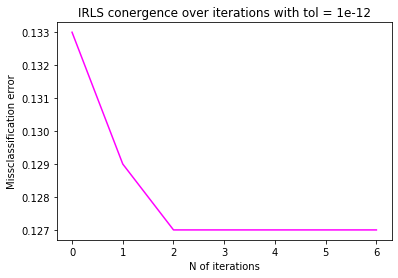

In [30]:
# read data
data = pd.read_csv("data.csv", header=None)
X = data.drop(data.columns[2], axis=1)
y = data[2]

w, s, iter, LL = fit_logistic(X, y, tol = 1e-12, max_itr = 50)
plt.plot(range(iter),s, c = 'magenta')
plt.xlabel('N of iterations')
plt.ylabel('Missclassification error')
plt.title('IRLS conergence over iterations with tol = 1e-12')
plt.show()

## 3.Adaboost (programming exercise)

In [56]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import seaborn as sns

In [57]:
# Read Data

data = pd.read_csv("data.csv", header=None)
X = data.drop(data.columns[2], axis=1)
y = data[2]

In [58]:
# Here is the plot function

from typing import Optional
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_adaboost(X: np.ndarray,
                  y: np.ndarray,
                  clf=None,
                  sample_weights: Optional[np.ndarray] = None,
                  annotate: bool = False,
                  ax: Optional[mpl.axes.Axes] = None) -> None:


    assert set(y) == {-1, 1}

    if not ax:
        fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
        fig.set_facecolor('white')

    pad = 1
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad

    if sample_weights is not None:
        sizes = np.array(sample_weights) * X.shape[0] * 100
    else:
        sizes = np.ones(shape=X.shape[0]) * 100

    X_pos = X[y == 1]
    sizes_pos = sizes[y == 1]
    ax.scatter(*X_pos.T, s=sizes_pos, marker='+', color='orange')

    X_neg = X[y == -1]
    sizes_neg = sizes[y == -1]
    ax.scatter(*X_neg.T, s=sizes_neg, marker='.', c='magenta')

    if clf:
        plot_step = 0.01
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # If all predictions are positive class, adjust color map acordingly
        if list(np.unique(Z)) == [1]:
            fill_colors = ['orange']
        else:
            fill_colors = ['magenta', 'orange']

        ax.contourf(xx, yy, Z, colors=fill_colors, alpha=0.2)

    if annotate:
        for i, (x, y) in enumerate(X):
            offset = 0.05
            ax.annotate(f'$x_{i + 1}$', (x + offset, y - offset))

    ax.set_xlim(x_min+0.5, x_max-0.5)
    ax.set_ylim(y_min+0.5, y_max-0.5)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

Train error: 0.0%


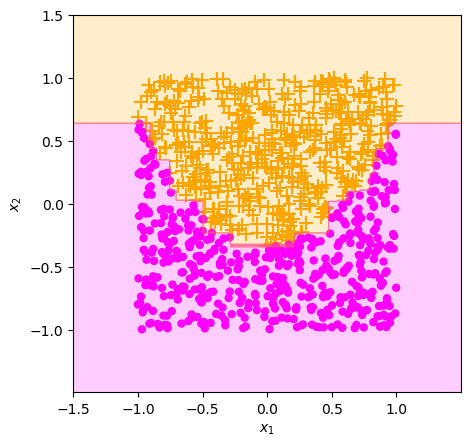

In [59]:
# Benchmarking with scikit-learn to get the reference solution, we plot the train error here as well

from sklearn.ensemble import AdaBoostClassifier

reference = AdaBoostClassifier(n_estimators=1000, algorithm='SAMME').fit(X.values, y.values)
plot_adaboost(X.values, y.values, reference)

train_err = (bench.predict(X.values) != y.values).mean()
print(f'Train error: {train_err:.1%}')

In [60]:
#We set the initial uniform sample weights outside of the for-loop and set the weights for t+1 within each 
#iteration t, unless it is the last iteration.
#We save an array of sample weights on the fitted model, so we can visualize the sample weights at each iteration.


# Parameters : X vector input
#              y vector output
#              iters : no of iterations
# choose a linear classifier

# Works for class {-1,1}, pay attention if want to use for {0,1} class!
# This checks the format of input data, 

class AdaBoost:

    def __init__(self):
        self.stumps = None
        self.stump_weights = None
        self.errors = None
        self.sample_weights = None

    def _check_X_y(self, X, y):
        assert set(y) == {-1, 1} 
        return X, y

    
from sklearn.tree import DecisionTreeClassifier

def fit(self, X: np.ndarray, y: np.ndarray, iters: int):

    X, y = self._check_X_y(X, y)
    n = X.shape[0]

    # init numpy arrays
    self.sample_weights = np.zeros(shape=(iters, n))
    self.stumps = np.zeros(shape=iters, dtype=object)
    self.stump_weights = np.zeros(shape=iters)
    self.errors = np.zeros(shape=iters)

    # initialize weights uniformly
    self.sample_weights[0] = np.ones(shape=n) / n

    for t in range(iters):
        
        # fit  weak learner
        curr_sample_weights = self.sample_weights[t]
        
        stump = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
        stump = stump.fit(X, y, sample_weight=curr_sample_weights)
        

        # calculate error and stump weight from weak learner prediction
        stump_pred = stump.predict(X)
        err = curr_sample_weights[(stump_pred != y)].sum()
        stump_weight = np.log((1 - err) / err) / 2

        # update sample weights
        new_sample_weights = (
            curr_sample_weights * np.exp(-stump_weight * y * stump_pred)
        )
        
        new_sample_weights /= new_sample_weights.sum()

        # If it is not the final iteration, update sample weights for t+1
        if t+1 < iters:
            self.sample_weights[t+1] = new_sample_weights

        # save results for each iteration
        self.stumps[t] = stump
        self.stump_weights[t] = stump_weight
        self.errors[t] = err

    return self

In [61]:
#We can use the already fitted model to make predictions

def predict(self, X):
    
    stump_preds = np.array([stump.predict(X) for stump in self.stumps])
    return np.sign(np.dot(self.stump_weights, stump_preds))

Train error for M = 10: 5.8%


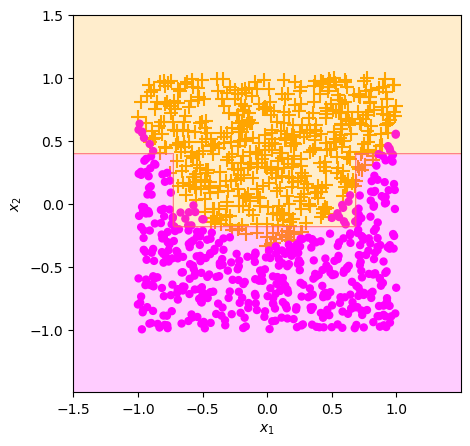

In [62]:
# predict using the classifier for a M = 10 iterations
AdaBoost.fit = fit
AdaBoost.predict = predict

clf = AdaBoost().fit(X.values, y.values, iters=10)
plot_adaboost(X.values, y.values, clf)

train_err = (clf.predict(X.values) != y.values).mean()
print(f'Train error for M = 10: {train_err:.1%}')

Train error for M =100: 0.4%


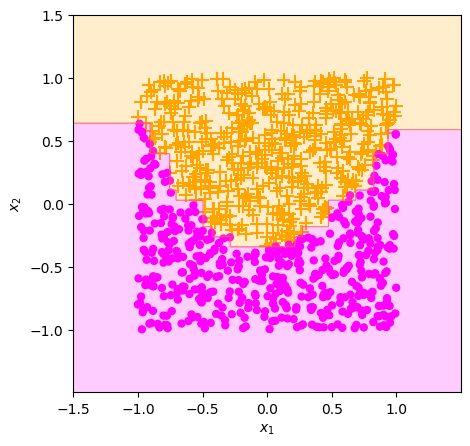

In [63]:
# predict using the classifier for a M =100
AdaBoost.fit = fit
AdaBoost.predict = predict

clf = AdaBoost().fit(X.values, y.values, iters=100)
plot_adaboost(X.values, y.values, clf)

train_error = (clf.predict(X.values) != y.values).mean()
print(f'Train error for M =100: {train_error:.1%}')

Train error for M =1000: 0.0%


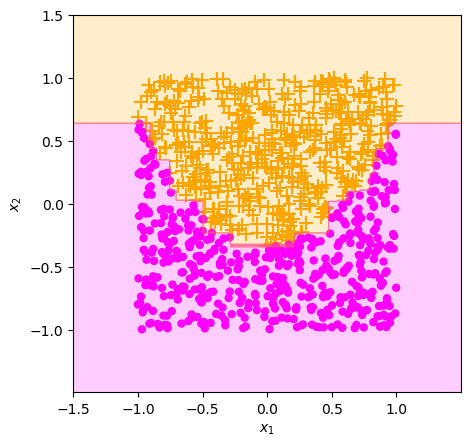

In [64]:
# predict using the classifier for a M = 1000

AdaBoost.fit = fit
AdaBoost.predict = predict

clf = AdaBoost().fit(X.values, y.values, iters=1000)
plot_adaboost(X.values, y.values, clf)

train_err = (clf.predict(X.values) != y.values).mean()
print(f'Train error for M =1000: {train_err:.1%}')

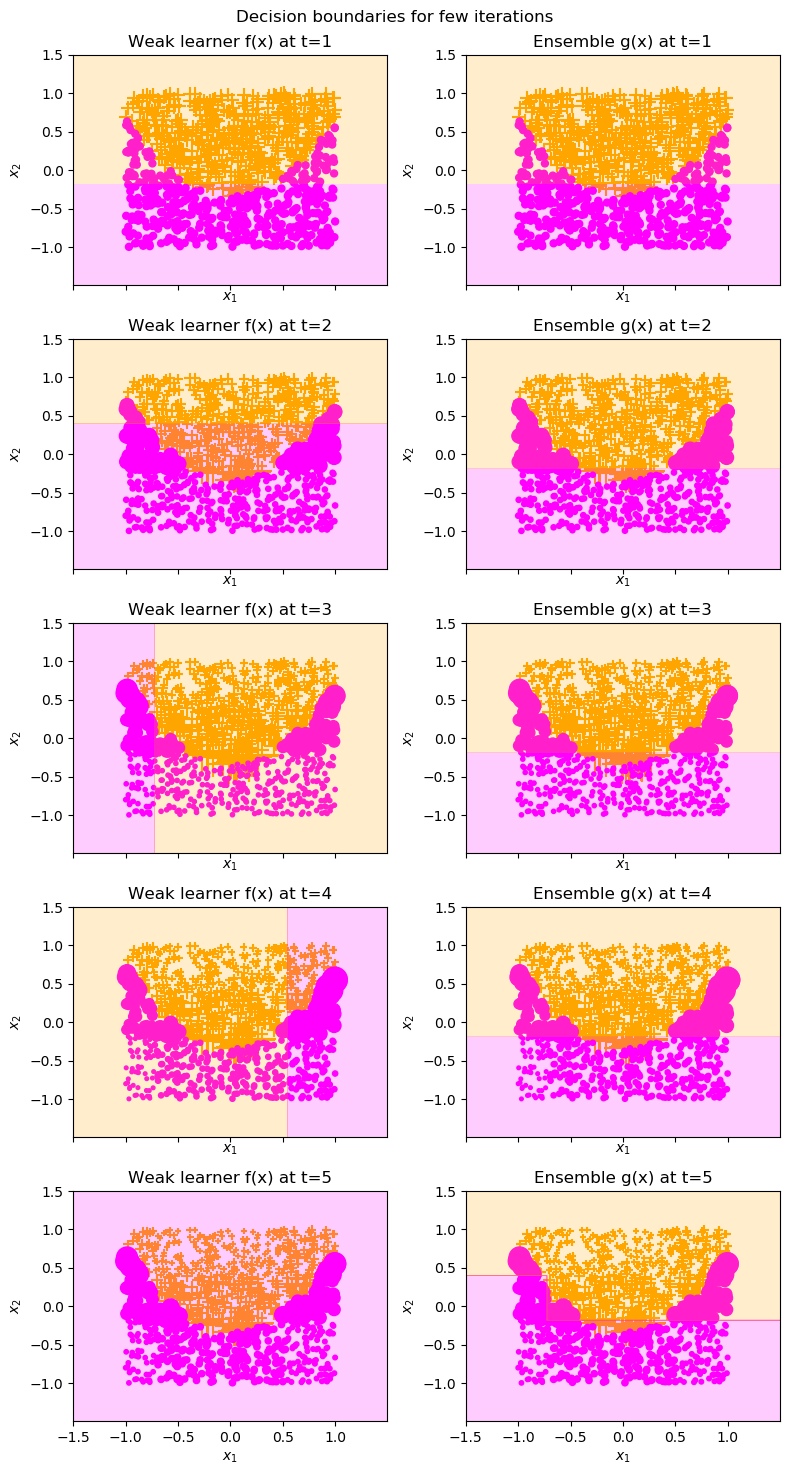

In [65]:
# Draw plot for the first few iterations of the Adaboost

def truncate_adaboost(clf, t: int):

    assert t > 0 
    from copy import deepcopy
    new_clf = deepcopy(clf)
    new_clf.stumps = clf.stumps[:t]
    new_clf.stump_weights = clf.stump_weights[:t]
    return new_clf


def plot_staged_adaboost(X, y, clf, iters=5):
    """ Plot weak learner at each iteration. """

    # larger grid for multiple subplots
    fig, axes = plt.subplots(figsize=(8, iters*3),
                             nrows=iters,
                             ncols=2,
                             sharex=True,
                             dpi=100)
    
    fig.set_facecolor('white')

    _ = fig.suptitle('Decision boundaries for few iterations')
    for i in range(iters):
        ax1, ax2 = axes[i]

        # Plot weak learner
        _ = ax1.set_title(f'Weak learner f(x) at t={i + 1}')
        plot_adaboost(X, y, clf.stumps[i],
                      sample_weights=clf.sample_weights[i],
                      annotate=False, ax=ax1)

        # Plot ensemble
        trunc_clf = truncate_adaboost(clf, t=i + 1)
        _ = ax2.set_title(f'Ensemble g(x) at t={i + 1}')
        plot_adaboost(X, y, trunc_clf,
                      sample_weights=clf.sample_weights[i],
                      annotate=False, ax=ax2)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

clf = AdaBoost().fit(X.values, y.values, iters=5)
plot_staged_adaboost(X.values, y.values, clf)

In [66]:
# Finally, plot as function of M the three types of errors: (i) classification
# error of individual weak learner, (ii) classification error of the ensemble,
# and (iii) the exponential loss of the ensemble


# epsilon_m, ensemble_error_list, exponential_loss_list, ensemble_error are the outputs to be visualized
def adaboost(X, Y, M):
    
    N = len(Y)

    # weights list
    weight_vector = np.ones(N)/N
    weight_vector_list = []
    weight_vector_list.append(weight_vector)

    epsilon_m = []  # estimation of errors
    beta_m = []  # estimation of weights
    f_m = [] # estimation for prediction

    ensemble_error_list = []
    exponential_loss_list = []
    ensemble_pred = 0

    for m in range(M):
        
        estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
        estimator.fit(X, Y, sample_weight=weight_vector)
        y_pred = estimator.predict(X)
        
        f_m.append(y_pred)
    

        miss = (y_pred != Y)

        estimator_error = np.mean(np.average(miss, weights=weight_vector, axis=0))
        epsilon_m.append(estimator_error.copy())

        estimator_weight = 1/2 * np.log((1. - estimator_error)/estimator_error)
        beta_m.append(estimator_weight)

        ensemble_pred += estimator_weight*y_pred
        miss_ensemble = (np.sign(ensemble_pred) != Y)
        
        ensemble_error = np.mean(np.average(miss_ensemble, weights=weight_vector, axis=0))
        ensemble_error_list.append(ensemble_error.copy())
        

        exponential_loss = np.sum(np.exp(-1.*Y*ensemble_pred))
        exponential_loss_list.append(exponential_loss.copy())

        weight_vector *= np.exp(-1.*estimator_weight*y_pred*Y)
        weight_vector_list.append(weight_vector)

    f_m = np.asarray(f_m)
    
    epsilon_m = np.asarray(epsilon_m)
    
    beta_m = np.asarray(beta_m)
    
    ensemble_error_list = np.asarray(ensemble_error_list)
    
    exponential_loss_list = np.asarray(exponential_loss_list)
    
    weight_vector_list = np.asarray(weight_vector_list)

    return epsilon_m, ensemble_error_list, exponential_loss_list, ensemble_error

In [67]:
# Adaboost algorithm for M =100

epsilon_m, ensemble_error_list, exponential_loss_list, emsemble_error = adaboost(X, y, 100)

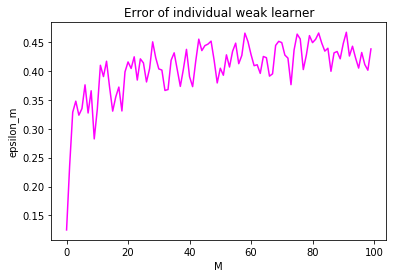

In [68]:
# Plot of the error of individual weak learner

plt.plot(range(len(epsilon_m)), epsilon_m, c='magenta')
plt.xlabel('M')
plt.ylabel('epsilon_m')
plt.title('Error of individual weak learner')
plt.show()

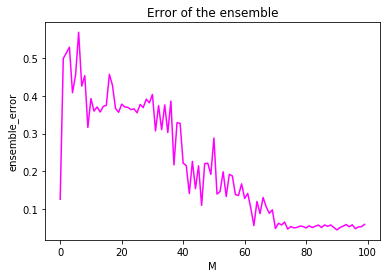

In [69]:
# Plot of the error of the ensemble

plt.plot(range(len(ensemble_error_list)), ensemble_error_list, c = 'magenta')
plt.xlabel('M')
plt.ylabel('ensemble_error')
plt.title('Error of the ensemble')
plt.show()

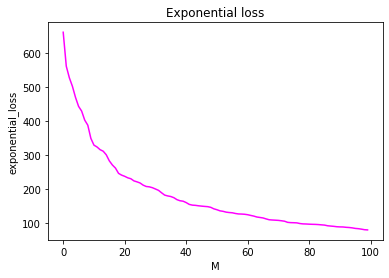

In [70]:
# Plot of the error of the exponential loss

plt.plot(range(len(exponential_loss_list)), exponential_loss_list, c = 'magenta')
plt.xlabel('M')
plt.ylabel('exponential_loss')
plt.title('Exponential loss')
plt.show()

In [71]:
# Adaboost algorithm for M =1000

epsilon_m, ensemble_error_list, exponential_loss_list, emsemble_error = adaboost(X, y, 1000)

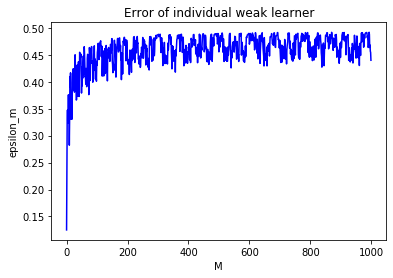

In [72]:
# Plot of the error of individual weak learner

plt.plot(range(len(epsilon_m)), epsilon_m, c='blue')
plt.xlabel('M')
plt.ylabel('epsilon_m')
plt.title('Error of individual weak learner')
plt.show()

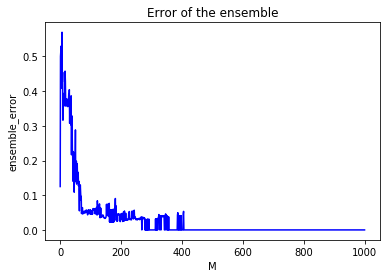

In [73]:
# Plot of the error of the ensemble

plt.plot(range(len(ensemble_error_list)), ensemble_error_list, c = 'blue')
plt.xlabel('M')
plt.ylabel('ensemble_error')
plt.title('Error of the ensemble')
plt.show()

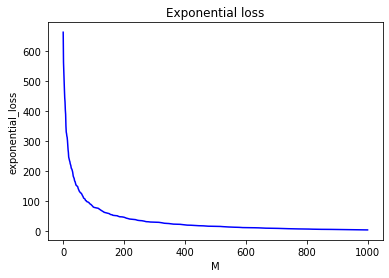

In [74]:
# Plot of the error of the exponential loss

plt.plot(range(len(exponential_loss_list)), exponential_loss_list, c = 'blue')
plt.xlabel('M')
plt.ylabel('exponential_loss')
plt.title('Exponential loss')
plt.show()